(counterfactual)=
# Counterfactuals with the do-operator in PyMC

:::{post} August, 2023
:tags: causal inference, do-operator, graph mutation
:category: beginner, explanation
:author: Benjamin T. Vincent
:::

INTRO HERE ...

Additional examples of calculating counterfactuals can be seen in the following notebooks: {ref}`excess_deaths`, {ref}`interrupted_time_series`, and {ref}`regression_discontinuity`.

## Set up the notebook

In [1]:
from copy import copy

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from packaging import version

:::{include} ../extra_installs.md
:::

This notebook relies on experimental functionality currently in the [pymc-experimental](https://github.com/pymc-devs/pymc-experimental) repository. In the near future this will be moved into the main [pymc](https://github.com/pymc-devs/pymc) repository.

In [2]:
# Import additional libraries that are not dependencies of PyMC
import daft
import pymc_experimental as pmx

# Check we have the necessary versions to get the new experimental functionality.
assert version.parse(pm.__version__) >= version.parse("5.5.0")
assert version.parse(pmx.__version__) >= version.parse("0.0.7")

# import the new functionality
from pymc_experimental.model_transform.conditioning import do, observe

In [3]:
RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

## Setting up the problem

In this section, I adapt an example from Chapter 4 (section 4.2.3) of {cite:t}`pearl2016causal`. The example is based around a causal DAG (see below) where we are interested in the level of homework $H$ on exam scores $Y$. Though we have a third variable (encouragement, $X$) which affects exam score directly and is partially mediated via changing the level of homework done. But given that our primary relationship of interest is $H \rightarrow Y$ then we can think of $X$ as a counfounding variable.

/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


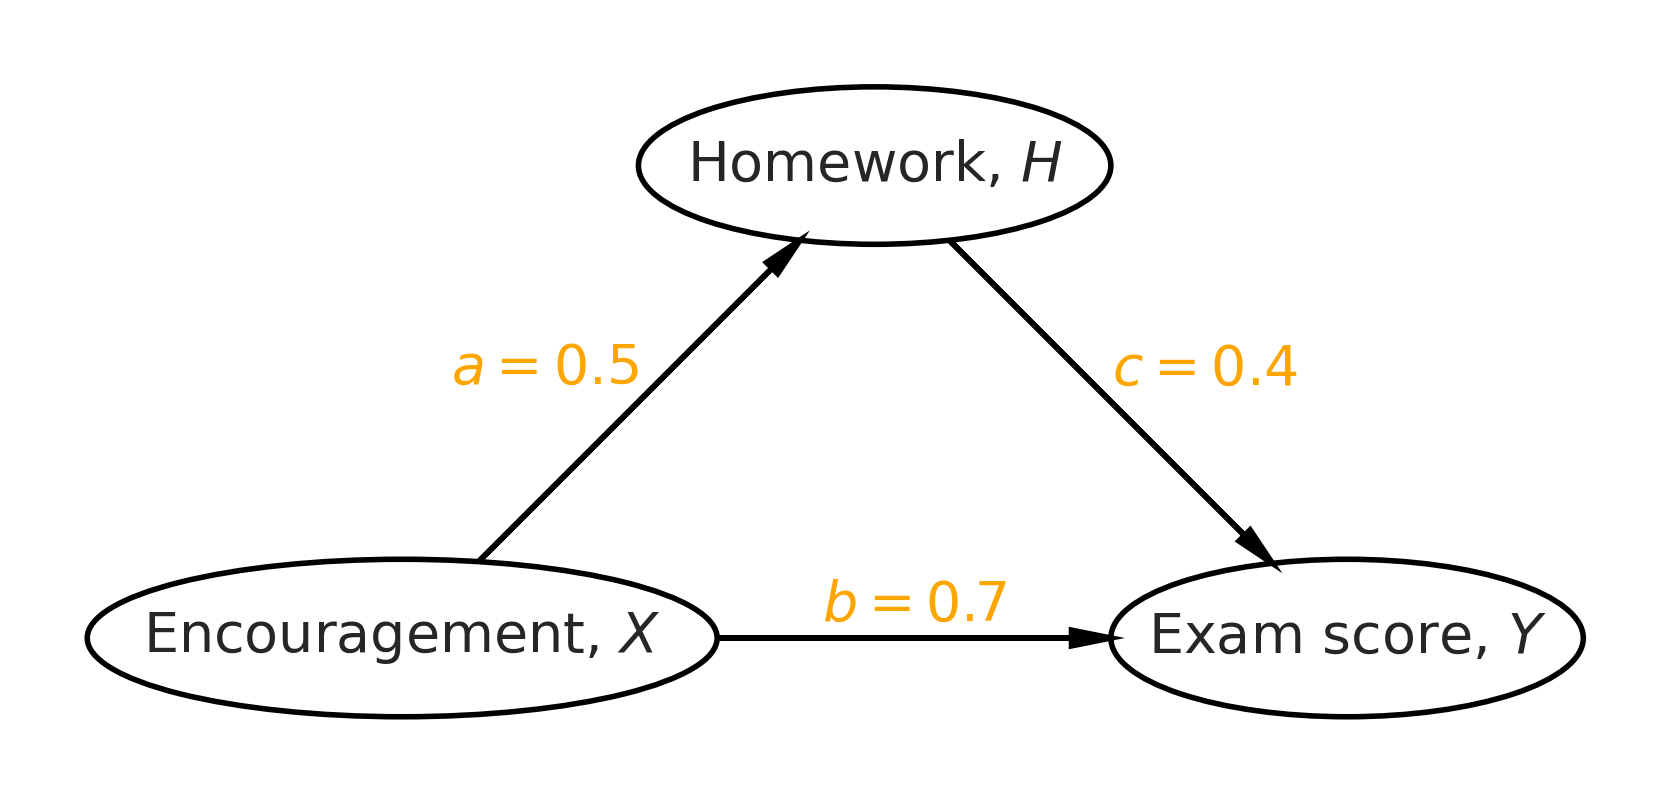

In [4]:
pgm = daft.PGM(dpi=200, grid_unit=3)
pgm.add_node("x", "Encouragement, $X$", 0, 0, aspect=4)
pgm.add_node("h", "Homework, $H$", 1, 1, aspect=3)
pgm.add_node("y", "Exam score, $Y$", 2, 0, aspect=3)
pgm.add_edge("x", "h", label=r"$a=0.5$", xoffset=-0.6, label_params={"color": "orange"})
pgm.add_edge("h", "y", label=r"$c=0.4$", xoffset=+0.6, label_params={"color": "orange"})
pgm.add_edge("x", "y", label=r"$b=0.7$", label_params={"color": "orange"})
pgm.render();

The variables $X, H, Y$ are standardised, so have zero-mean and unit standard deviation.

The example states that we already know the true causal effects $(a=0.5, b=0.7, c=0.4)$ which they say could be point estimates obtained from inference with population data. So let's define these values in a dictionary:

In [5]:
true_values = {"a": 0.5, "b": 0.7, "c": 0.4}

There is one particular student of interest, Joe, who has measurements $x=0.5, h=1, y=1.5$. Let's define these values in a dictionary:

In [6]:
joes_observations = {"x": [0.5], "h": [1.0], "y": [1.5]}

The key question at hand is: **What would Joe's score have been if he doubled his study time?**

:::{note}
There is a slight issue with this phrasing of "doubling Joe's study time." The example considers Joe's actual study time as 1.5, and his counterfactual doubled study time as $h=2$. But because all the variables are standardised, this isn't a doubling of absolute study time, it's a move from 1 std above the average to 2 std above the average homework time. So the phrasing in the example is a little inexact, but let's roll with it.
:::

## A Bayesian _statistical_ approach 

Coming from a statistical background, it would be tempting to build a data generating process such as this:

$$
\begin{aligned}
a, b, c &\sim \mathrm{Normal}(0, 1) \\
\sigma_X, \sigma_H, \sigma_Y &\sim \mathrm{HalfNormal}(1) \\
x_i &\sim \mathrm{Normal}(0, \sigma_X) \\
h_i &\sim \mathrm{Normal}(a \cdot x_i , \sigma_H) \\
y_i &\sim \mathrm{Normal}(b \cdot x_i + c \cdot h_i, \sigma_Y) \\
\end{aligned}
$$

OR SHOULD THIS BE

$$
\begin{aligned}
a, b, c &\sim \mathrm{Normal}(0, 1) \\
\sigma_X, \sigma_H, \sigma_Y &\sim \mathrm{HalfNormal}(1) \\
x_i &\sim \mathrm{Normal}(0, \sigma_X) \\
h_i &\sim \mathrm{Normal}(a \cdot X , \sigma_H) \\
y_i &\sim \mathrm{Normal}(b \cdot X + c \cdot (a \cdot x_i), \sigma_Y) \\
\end{aligned}
$$

**TODO: Either write briefly about why this approach is problematic OR continue with the full example so that we can directly compare and contrast the two approaches.**

## A Bayesian structural causal modeling (SCM) approach

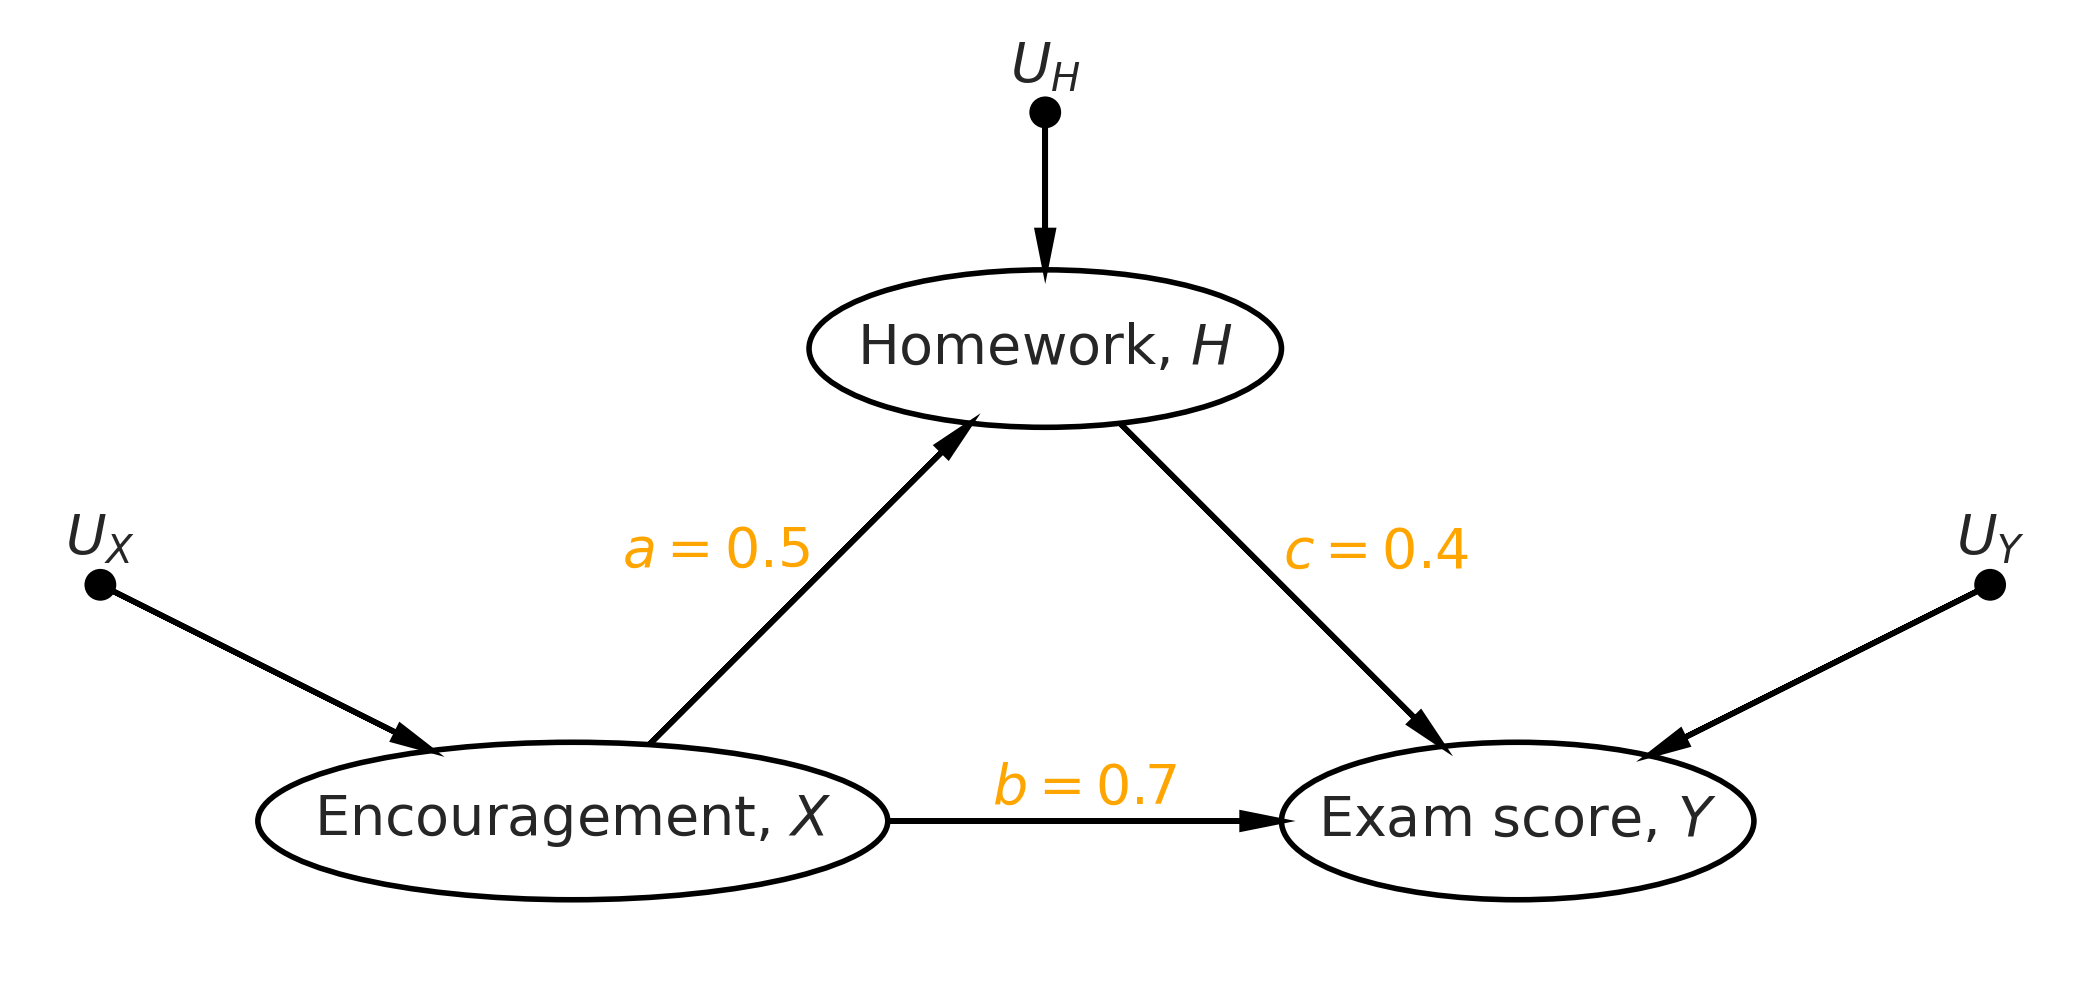

In [7]:
pgm = daft.PGM(dpi=200, grid_unit=3)
pgm.add_node("x", "Encouragement, $X$", 0, 0, aspect=4)
pgm.add_node("h", "Homework, $H$", 1, 1, aspect=3)
pgm.add_node("y", "Exam score, $Y$", 2, 0, aspect=3)
pgm.add_node("uh", "$U_H$", 1, 1.5, fixed=True)
pgm.add_node("ux", "$U_X$", -1, 0.5, fixed=True)
pgm.add_node("uy", "$U_Y$", 3, 0.5, fixed=True)
pgm.add_edge("uh", "h")
pgm.add_edge("ux", "x")
pgm.add_edge("uy", "y")
pgm.add_edge("x", "h", label=r"$a=0.5$", xoffset=-0.6, label_params={"color": "orange"})
pgm.add_edge("h", "y", label=r"$c=0.4$", xoffset=+0.6, label_params={"color": "orange"})
pgm.add_edge("x", "y", label=r"$b=0.7$", label_params={"color": "orange"})
pgm.render();

The model is standardized, so all variables have mean 0 and std 1. They define the SCM as:

$$
\begin{aligned}
X &= U_X \\
H &= a \cdot X + U_H \\
Y &= b \cdot X + c \cdot H + U_Y \\
\end{aligned}
$$

where $U_X, U_H, U_Y \sim \mathrm{Normal}(0, 1)$.

It is important to bear in mind that both the observations $X, H, Y$ and the exogenous variables $U_X, U_H, U_Y$ are all vectors.

:::{important}
The fact that the exogenous variables $U_X, U_H, U_Y$ are vectors is important. By default, we might focus on the data nodes $X, H, Y$ and think of these as vectors of observations which could be normally distributed with some standard deviation. So we might be tempted to think of $U_X, U_H, U_Y$ simply as levels of measurement error and think of the model like this:

$$
\begin{aligned}
a, b, c &\sim \mathrm{Normal}(0, 1) \\
U_X, U_H, U_Y &\sim \mathrm{HalfNormal}(1) \\
X &\sim \mathrm{Normal}(0, U_X) \\
H &\sim \mathrm{Normal}(a \cdot X , U_H) \\
Y &\sim \mathrm{Normal}(b \cdot X + c \cdot H, U_Y) \\
\end{aligned}
$$
:::

As you can see, we don't have any likelihood terms yet, so this SCM is not quite in the form yet where we can think of it as a Bayesian causal model. So we can re-write the SCM above into something a bit more famliar by: adding our prior knowledge over the parameters $a, b, c$, and the exogenous factors $U_X, U_H, U_Y$, and define normal likelihood functions for the observations with very small standard deviations:

$$
\begin{aligned}
a, b, c &\sim \mathrm{Normal}(0, 1) \\
U_X, U_H, U_Y &\sim \mathrm{Normal}(0, 1) \\
X &\sim \mathrm{Normal}(U_X, 0.001) \\
H &\sim \mathrm{Normal}(a \cdot X + U_H, 0.001) \\
Y &\sim \mathrm{Normal}(b \cdot X + c \cdot H + U_Y, 0.001) \\
\end{aligned}
$$

In this notebook, we are going to use these parameters to generate simulated population level data. We will then use Bayesian inference to try to recover these values (with a full posterior distriubtion of course) based on the simulated population data.

There is one particular student of interest, Joe, who has measurements $x=0.5, h=1, y=1.5$. In the example we want to know **What would Joe's score have been if he doubled his study time?**

### Define a PyMC model

Let's implement that in a PyMC model:

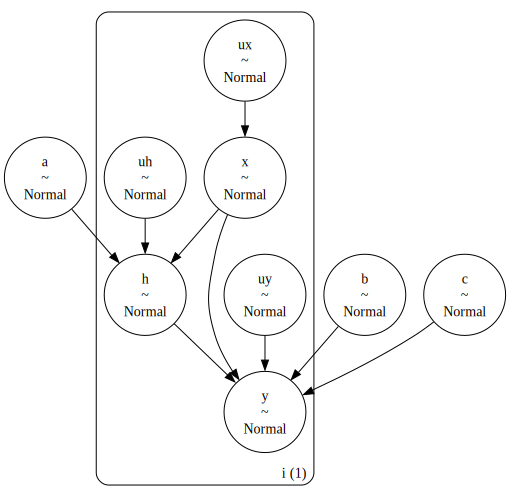

In [8]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    a = pm.Normal("a")
    b = pm.Normal("b")
    c = pm.Normal("c")
    # ux = pm.Normal("ux", mu=0.5, dims="i")
    # uh = pm.Normal("uh", mu=0.75, dims="i")
    # uy = pm.Normal("uy", mu=0.75, dims="i")
    ux = pm.Normal("ux", mu=1.0, dims="i")
    uh = pm.Normal("uh", mu=1.0, dims="i")
    uy = pm.Normal("uy", mu=1.0, dims="i")
    x = pm.Normal("x", mu=ux, sigma=0.001, dims="i")
    h = pm.Normal("h", mu=a * x + uh, sigma=0.001, dims="i")
    y = pm.Normal("y", mu=b * x + c * h + uy, sigma=0.001, dims="i")

pm.model_to_graphviz(model_generative)

### Generate simulated data

This deviates from the example in the book, but here we are going to use the model to generate population data which we will then use to estimate the parameters $a, b, c, u_x, u_h, u_y$.

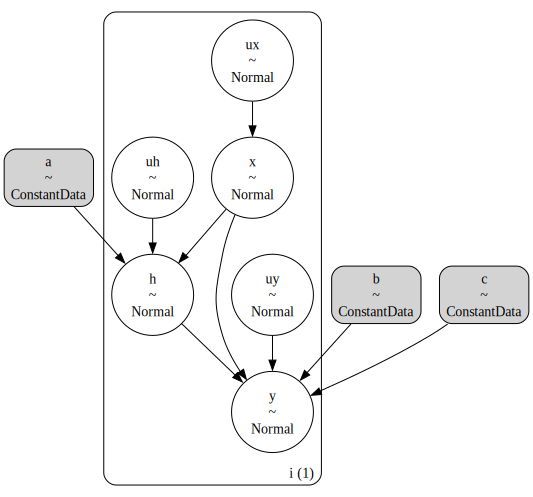

In [9]:
model_simulate = do(model_generative, true_values)
pm.model_to_graphviz(model_simulate)

Now let's simulate population data from the model.

In [10]:
N = 1_000

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N, random_seed=RANDOM_SEED)

observed = simulate.prior.to_dataframe().reset_index().drop(columns=["chain", "draw", "i"])
observed.tail()

Sampling: [h, uh, ux, uy, x, y]


,uh,x,uy,ux,h,y
995,1.376502,0.498951,-0.069684,0.498572,1.625976,0.930676
996,1.304045,2.076242,0.443130,2.075209,2.342449,2.832380
997,1.128204,0.392572,0.393088,0.394013,1.325287,1.199527
998,1.711460,-0.595083,2.724604,-0.595221,1.413644,2.873779
999,0.633217,0.549597,1.416780,0.548405,0.908291,2.163679


Now let's append the specific observation of Joe to the dataset. His observed values are: $x=0.5$, $h=1.0$, $y=1.5$.

**AND WE ARE ADDING UX, UH, UY. WHERE DO THESE COME FROM?**

In [11]:
joes_row = pd.DataFrame({"ux": [0.5], "uh": [0.75], "uy": [0.75], **joes_observations})
observed = pd.concat([observed, joes_row], ignore_index=True)
observed.tail()

,uh,x,uy,ux,h,y
996,1.304045,2.076242,0.443130,2.075209,2.342449,2.832380
997,1.128204,0.392572,0.393088,0.394013,1.325287,1.199527
998,1.711460,-0.595083,2.724604,-0.595221,1.413644,2.873779
999,0.633217,0.549597,1.416780,0.548405,0.908291,2.163679
1000,0.750000,0.500000,0.750000,0.500000,1.000000,1.500000


### Our counterfactual inference task

We are now going to evaluate the counterfactual query: **"What would Joe's score have been if he had doubled his study time?"**.

#### Step 1: Inference

We first need to estimate the path coefficients $a$, $b$, and $c$ from the observed population level data.

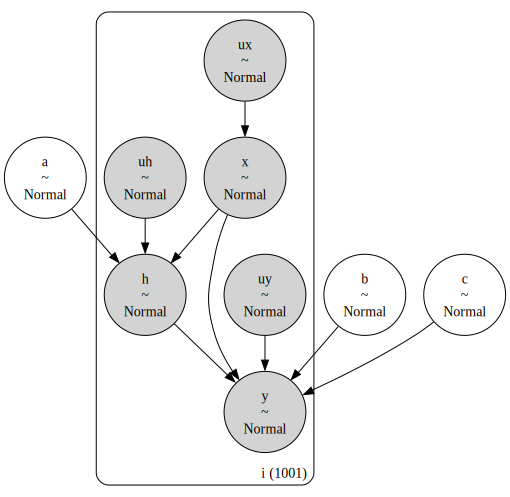

In [12]:
model_inference = observe(model_generative, observed.to_dict(orient="list"))
model_inference.set_dim("i", N + 1, coord_values=np.arange(N + 1))
pm.model_to_graphviz(model_inference)

In [13]:
with model_inference:
    idata = pm.sample(random_seed=RANDOM_SEED)
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [h, uh, ux, uy, x, y]


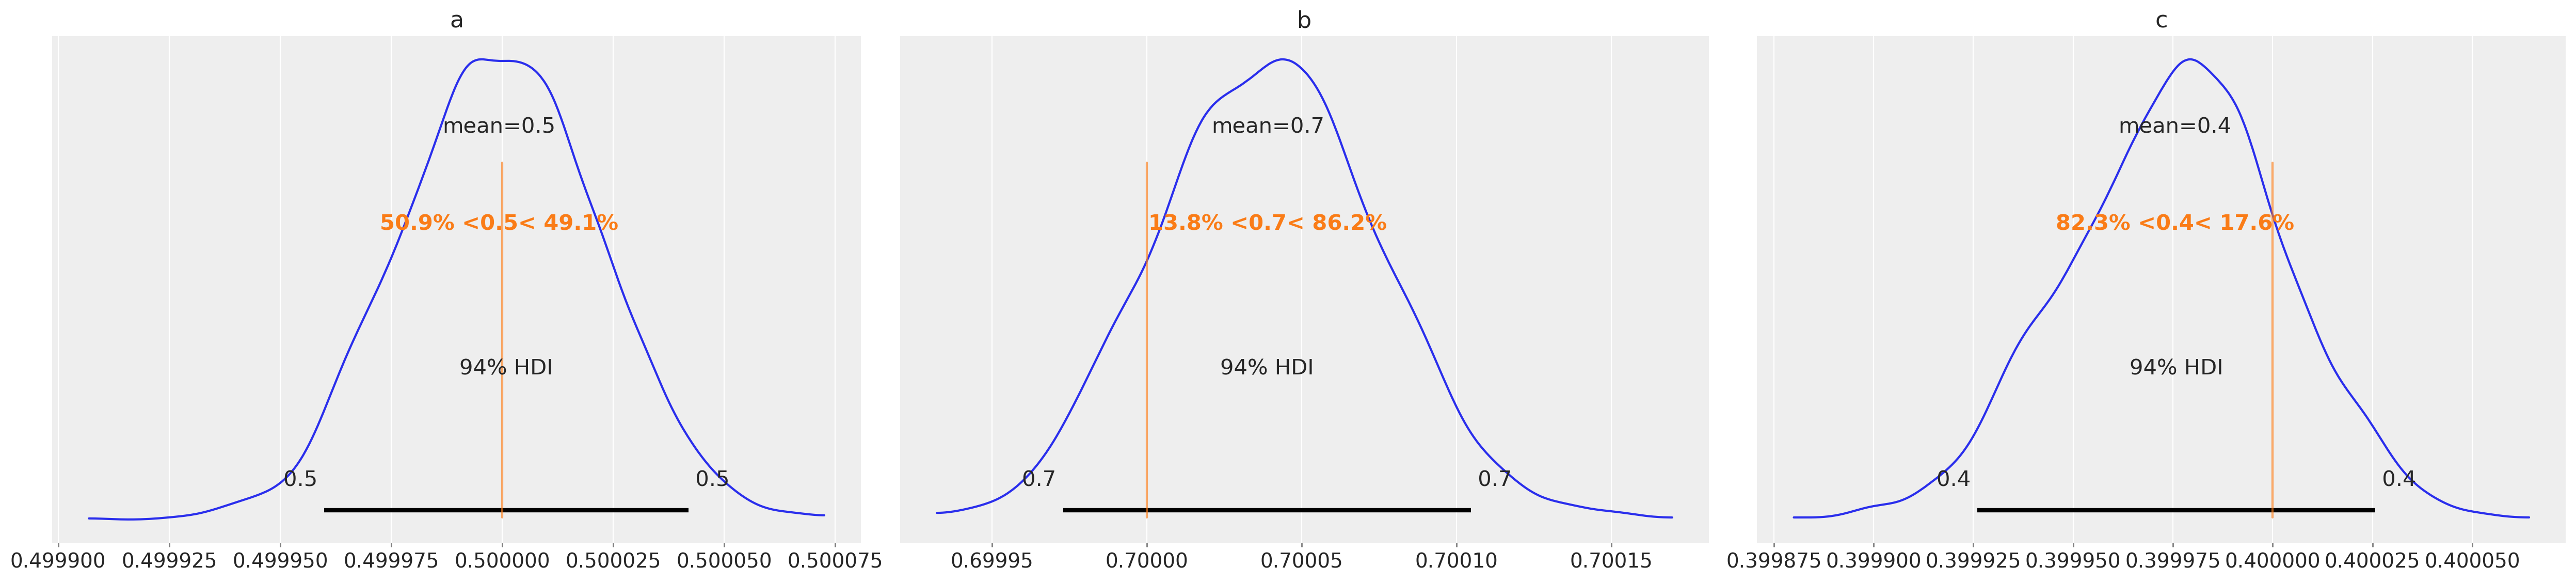

In [14]:
az.plot_posterior(
    idata,
    var_names=["a", "b", "c"],
    ref_val=[true_values["a"], true_values["b"], true_values["c"]],
);

Let's just santity check this by looking at the posterior predictive distribution of the exam score.

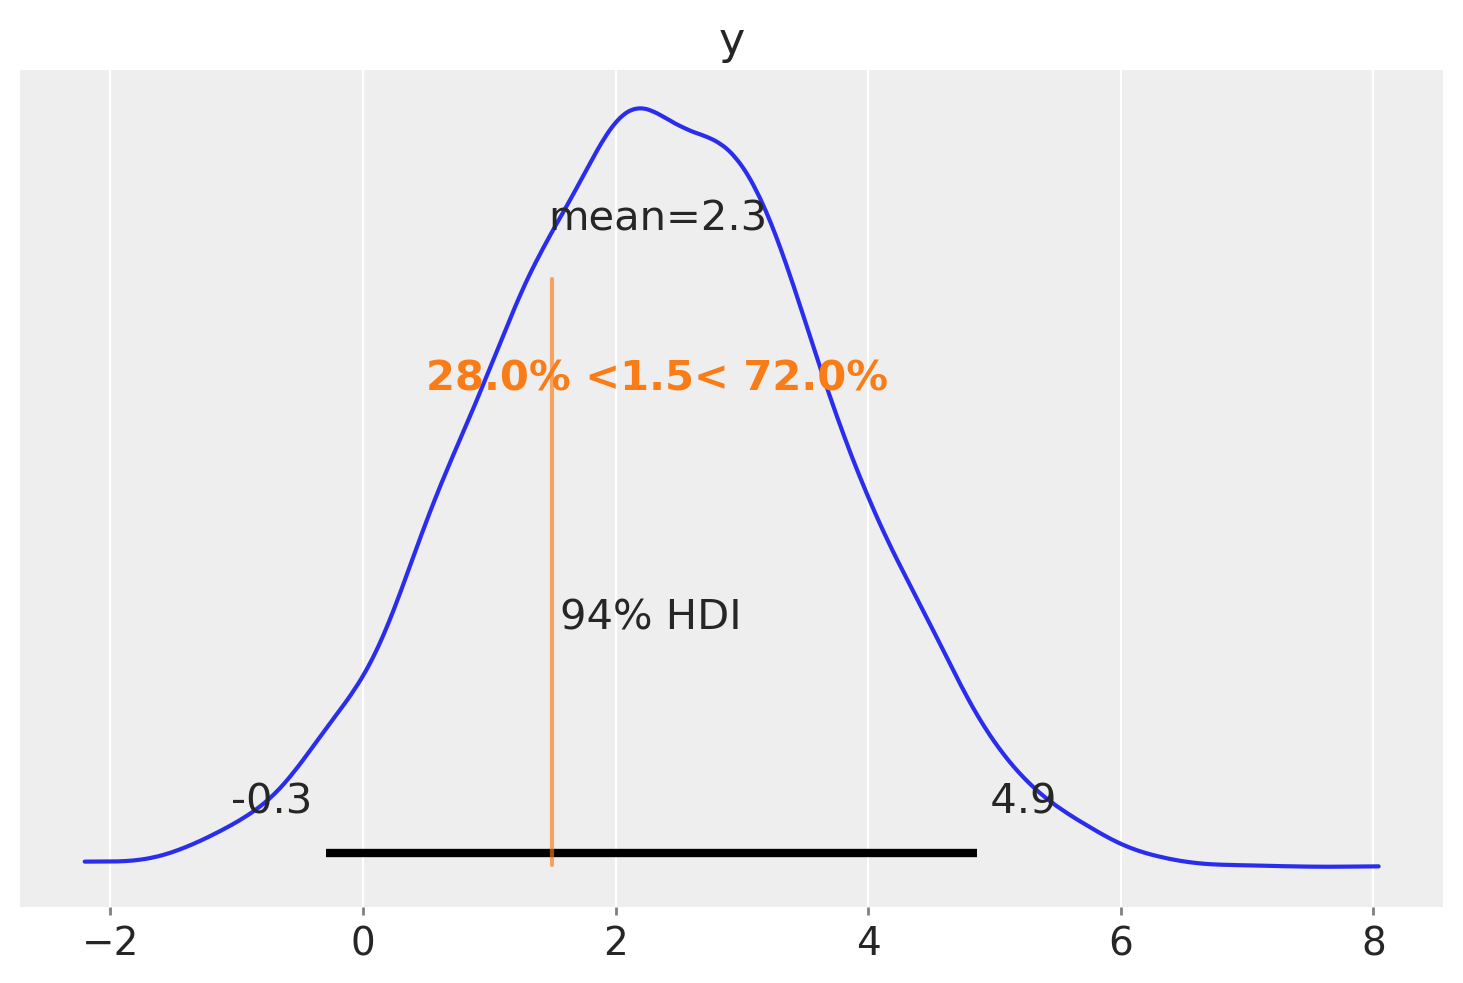

In [15]:
# posterior predictive exam score for Joe
# ref_val shows Joe's true exam score
az.plot_posterior(idata.posterior_predictive["y"].isel(i=N), ref_val=1.5);

Here we have Joe's actual exam score of $y=1.5$ shown by the vertical reference line, along with the posterior predictive distribution of exam scores. This represents plausible predictions of Joe's score after having estimated the posterior distribution of parameters $a, b, c$, based on the data. While we do have Joe's actual score, it is always worthwhile checking that a model is capable of reasonably accounting for observed data.

#### Step 2: Modify with the `do` operator

If we wanted to evaluate the counterfactual scenario of _only_ Joe doubling his homework, then we could intervene like this:

```python
df_counterfactual = copy(observed)
df_counterfactual["h"].iloc[-1] *= 2
```

If we wanted to stick to the original scenario then we'd do that. But just because we can, why don't we evaluate the counterfactual scenario that _everyone_ doubles their homework? We can still just focus in on the counterfacutal outcome just for Joe if we want.

In [16]:
df_counterfactual = copy(observed)
df_counterfactual["h"] *= 2
df_counterfactual.tail()

,uh,x,uy,ux,h,y
996,1.304045,2.076242,0.443130,2.075209,4.684898,2.832380
997,1.128204,0.392572,0.393088,0.394013,2.650573,1.199527
998,1.711460,-0.595083,2.724604,-0.595221,2.827288,2.873779
999,0.633217,0.549597,1.416780,0.548405,1.816582,2.163679
1000,0.750000,0.500000,0.750000,0.500000,2.000000,1.500000


Now we'll use the `do` operator to intervene on the graph where we provide the counterfactual data where everyone's homework time was doubled.

In [17]:
model_counterfactual = do(
    model_inference,
    {"h": df_counterfactual["h"], "x": df_counterfactual["x"]},
    prune_vars=True,
)

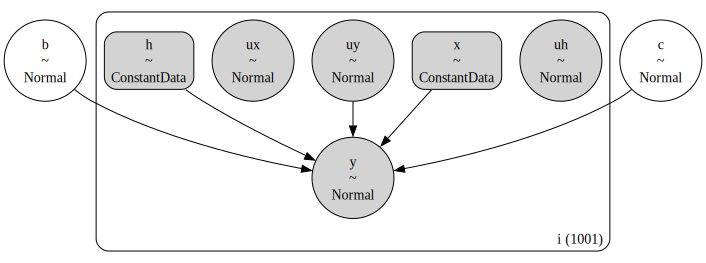

In [18]:
pm.model_to_graphviz(model_counterfactual)

This now gives us a model equivalent to the surgically mutated model after we intervened on the homework variable $h$.

/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


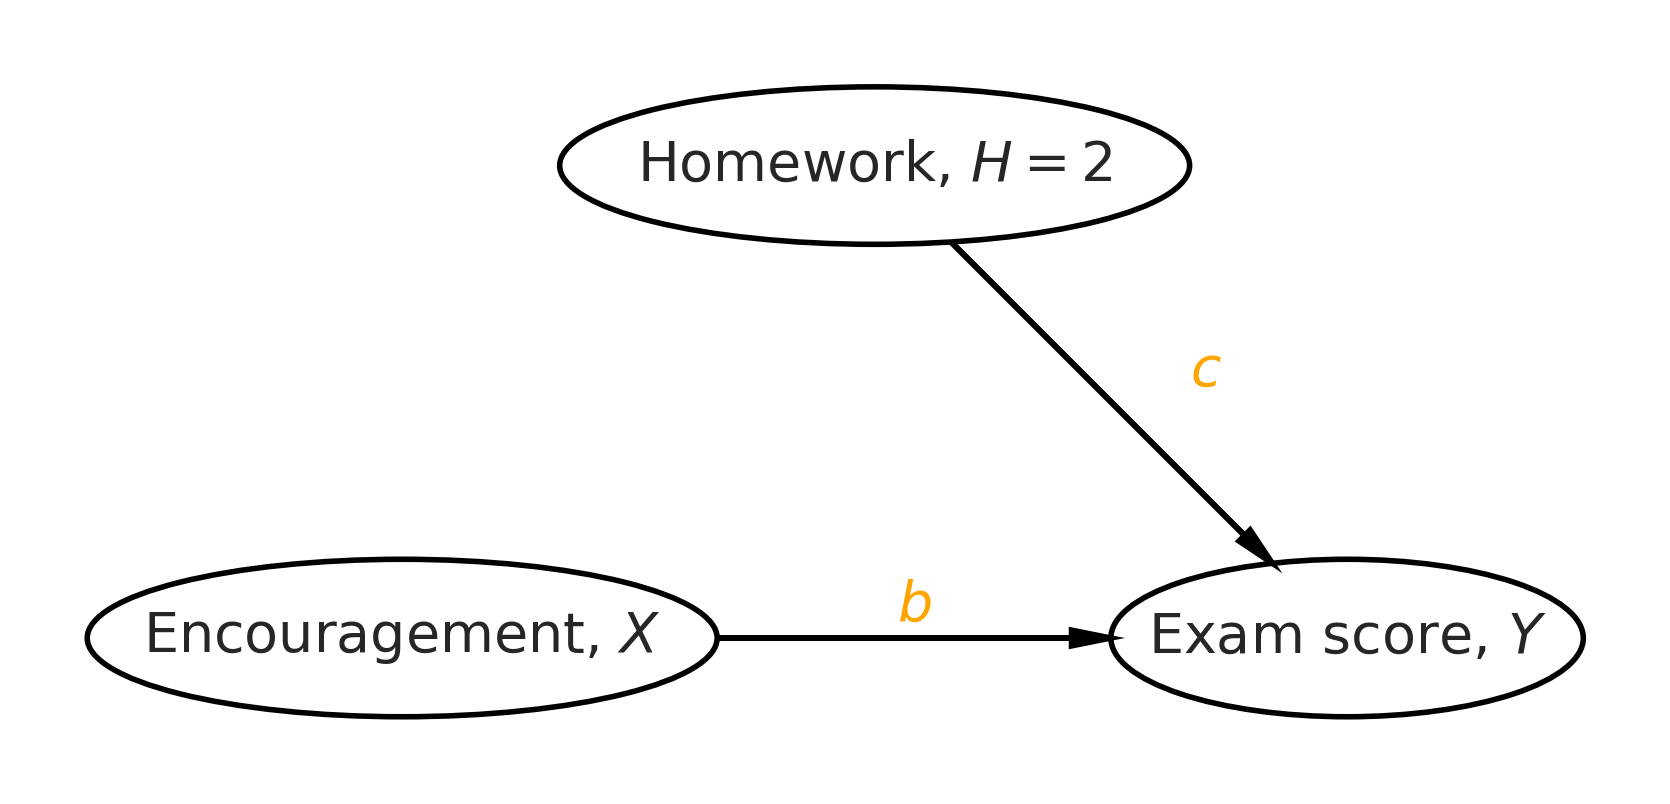

In [19]:
pgm = daft.PGM(dpi=200, grid_unit=3)
pgm.add_node("x", "Encouragement, $X$", 0, 0, aspect=4)
pgm.add_node("h", "Homework, $H=2$", 1, 1, aspect=4)
pgm.add_node("y", "Exam score, $Y$", 2, 0, aspect=3)
pgm.add_edge("h", "y", label=r"$c$", xoffset=+0.6, label_params={"color": "orange"})
pgm.add_edge("x", "y", label=r"$b$", label_params={"color": "orange"})
pgm.render();

We can plot the corresponding PyMC graphviz representation. It is more messy but it shows that the causal influence of $x$ on $h$ is now removed, and the homework variable is now updated.

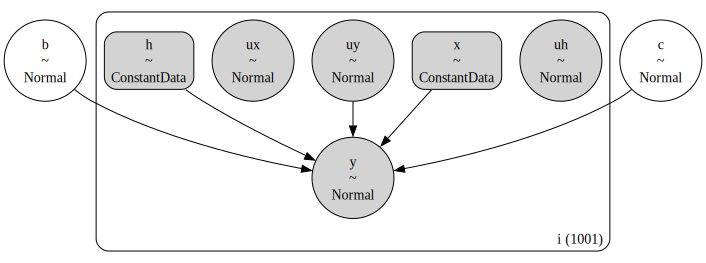

In [20]:
pm.model_to_graphviz(model_counterfactual)

#### Step 3: Counterfactual prediction

In [21]:
idata_counterfactual = pm.sample_posterior_predictive(
    idata,
    model=model_counterfactual,
    predictions=True,
    random_seed=RANDOM_SEED,
)

Sampling: [uh, ux, uy, y]


Now we can visualise the results.

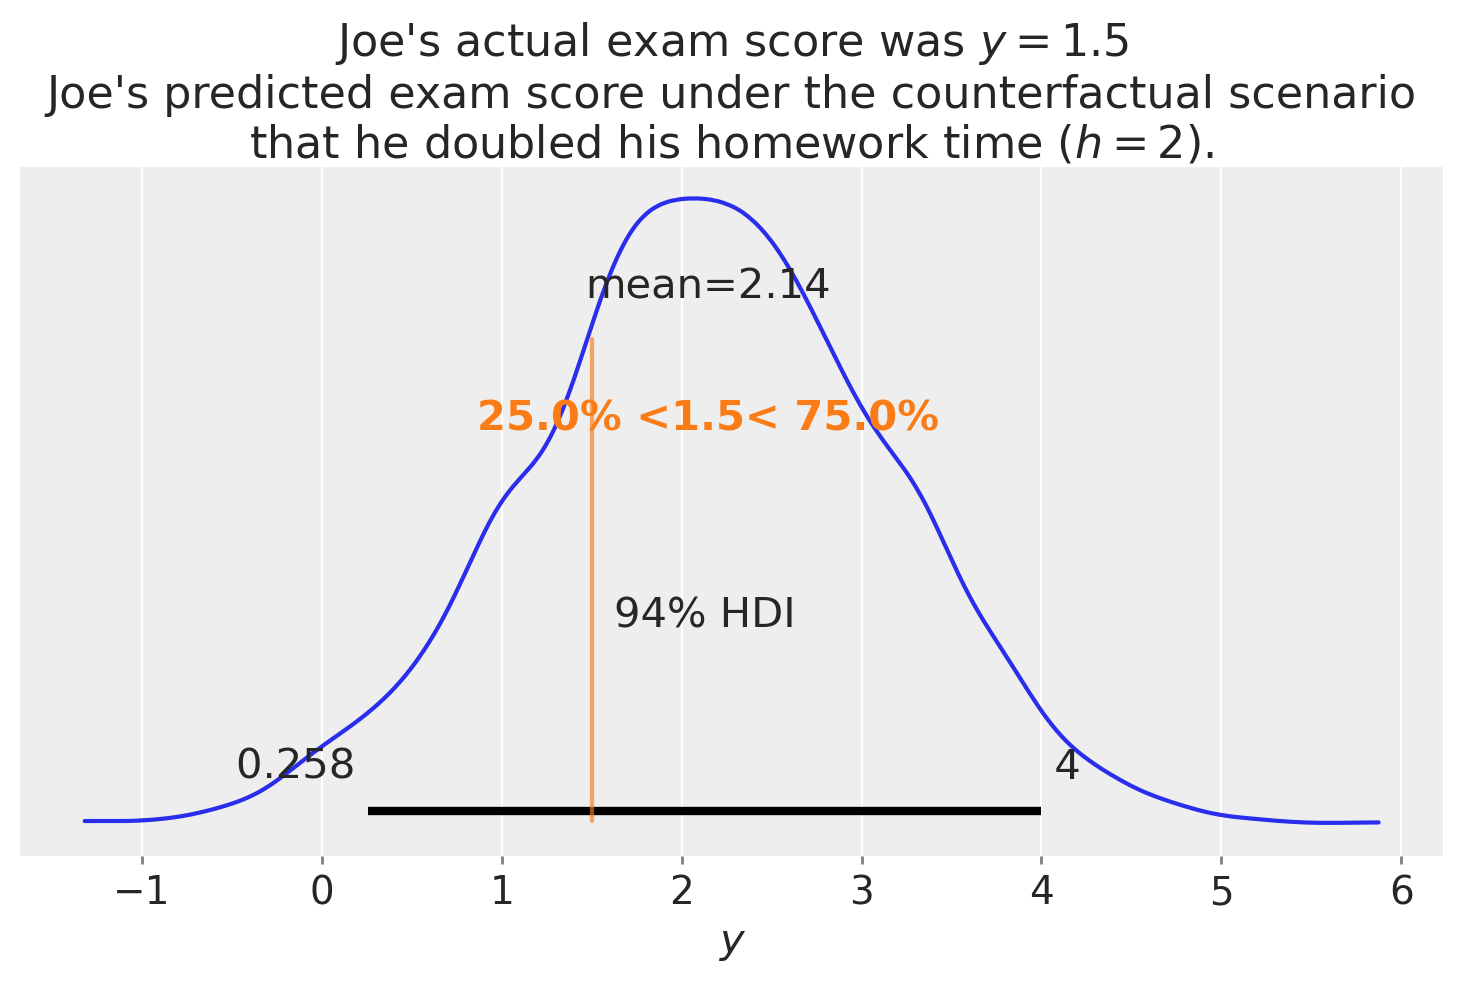

In [22]:
joe_y_actual = observed["y"].iloc[-1]
joe_y_counterfactual = idata_counterfactual.predictions["y"].sel(i=N)
ax = az.plot_posterior(joe_y_counterfactual, ref_val=joe_y_actual, round_to=3)
ax.set(
    title="Joe's actual exam score was $y=1.5$\n"
    + "Joe's predicted exam score under the counterfactual scenario that he doubled his homework time ($h=2$).",
    xlabel="$y$",
);

We can also calculate the standard deviation of the posterior predictive estimate of Joe's counterfactual score:

In [23]:
print(joe_y_counterfactual.std().data)

0.9947394399304105


## Summary

* Joe's actual score was $y=1.5$.
* The book calculates the counterfactual (point estimate) to be $y=1.9$.
* We get **XXXXXX**.
* The posterior predictive distribution over Joe's counterfactual scores is **XXXX**

## Authors
- Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in August 2023

## References

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Wed Aug 23 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.12.3
xarray  : 2023.6.0

pymc_experimental: 0.0.7
numpy            : 1.25.0
packaging        : 23.1
pandas           : 1.5.3
matplotlib       : 3.7.1
arviz            : 0.15.1
pymc             : 5.5.0
daft             : 0.1.2

Watermark: 2.3.1



:::{include} ../page_footer.md :::